# BEAT-PD Challenge

Challenge website : https://www.synapse.org/#!Synapse:syn20825169/wiki/596118

Data information : https://www.synapse.org/#!Synapse:syn20825169/wiki/600405


### Ideas/Doubts [Laureano]

VAD like thing to remove unwanted data?
modified MFCC?
X,Y,Z = relative positions or acceleration?

Imp: Predict per person. Maybe UBM like thing and adapt it

In [9]:
# Import required libraries

import pandas as pd
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

# Import required modules
from sklearn.preprocessing import StandardScaler

In [2]:
# Data paths

data_dir='/home/sjoshi/codes/python/BeatPD/data/BeatPD/'
path_save_accelerometer_plots='/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/'

In [3]:
def define_data_type(data_type):
    # Setup file names

    '''
    data_type={cis , real}

    If data_type is real, data_real_subtype 
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    '''
    if data_type=='cis':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'

    if data_type=='real':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'+data_real_subtype+'/'

    # Display labels
    df_train_label=pd.read_csv(path_train_labels)
    return path_train_data, df_train_label

In [4]:
def plot_accelerometer(data_type, path_accelerometer_plots, display_df_train_data=False):
    # Iterating through all the indexes contained in df_train_label
    for idx in df_train_label.index: 
        df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        # BUG ?  why this goes to 1000xxx sometimes? 
        display(df_train_data)
        # Prints the t x y z table if we want to see it
        #print(display(df_train_data) if display_df_train_data else '')

        # Following val_* variables are only used to format a cute title for the plots
        val_subject_id = df_train_label.loc[[idx]]['subject_id'].values[0]
        val_on_off = df_train_label.loc[[idx]]['on_off'].values[0]
        val_dyskinesia = df_train_label.loc[[idx]]['dyskinesia'].values[0]
        val_tremor = df_train_label.loc[[idx]]['tremor'].values[0]
        great_title = "{0} = on_off: {1}, dyskinesia: {2}, tremor: {3}".format(val_subject_id, val_on_off, val_dyskinesia, val_tremor)

        # The time doesn't have the same name depending on the data_type
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        
        # Normalize the data
        #df_train_data[['x','y','z']] = StandardScaler().fit_transform(df_train_data[['x','y','z']])
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

        
        df_train_data.plot(x=x_axis_data_type,legend=True, subplots=True,title=great_title)
        #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        # Save plot with the measurement_id as name of the file
        plt.savefig(path_accelerometer_plots+df_train_label["measurement_id"][idx]+'.png')
        plt.show()

In [5]:
def prepro_missing_values(df_train_label):
    # Replace NaN values with -1.0 because otherwise plotting triggers an error 
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label

def compute_symptoms_occurences_dataframe(df_train_label):
    df_train_label = prepro_missing_values(df_train_label=df_train_label)
    
    # Group data by subject_id 
    df_train_label_subject_id = df_train_label.groupby('subject_id')

    df_occurences = []
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    
    for key, value in df_train_label_subject_id :
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = df_train_label_subject_id.get_group(key).iloc[:,-3:][symptom].value_counts()

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(({'subject_id': key, 'symptom': symptom, 'symptom_value': symptom_value, 'occurence': symptom_occurence}))

    df_occurences = pd.DataFrame(df_occurences, columns=('subject_id', 'symptom', 'symptom_value', 'occurence'))

    # Change the default option to display all row with display(DF)
    # pd.set_option('display.max_rows', 1000)
    
    print('display df occurences')
    display(df_occurences)
    return df_occurences, df_train_label_subject_id


In [6]:
'''
This function plots the occurences of symptoms according to subject_id 

Arguments: 
- df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
- df_train_label_subject_id: contains df_train_label grouped by subject_id 
'''
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    
    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = df_occurences.subject_id.nunique() # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 10
    fig, axes = plt.subplots(nrows=nb_subjects_id, ncols=3, figsize=(10,height), sharey=True) # 3 cols for the 3 symptoms
    
    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop 
    # it is incremented
    patient = -1

    #Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    for key, value in df_train_label_subject_id :
        patient = patient + 1 # value used to position the plots (row)
        symptom_no = 0 # value only used to position the plots (col)
        for symptom in symptoms:
            subject_symptom = ' '.join([str(key), symptom]) # variable used to create a title for each plot
            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(kind='bar',
                                                                                  x=symptom,
                                                                                  title=subject_symptom, 
                                                                                  ax=axes[patient,symptom_no],
                                                                                  sharey=True)
                                                                                  
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1
    #plt.close(fig)

In [7]:
'''
Filters df_train_label according to a list of measurement_id we are interested in analyzing

Arguments:
- df_train_label: dataframe with labels
- list_measure_id: list of measurement_id 

Returns:
- df_train_label: filtered df_train_label containing only the measurements_id we are interested in 
'''
def interesting_patients(df_train_label, list_measurement_id):
    filter_measurement_id = df_train_label.measurement_id.isin(list_measurement_id)

    df_train_label = df_train_label[filter_measurement_id]
    display(df_train_label)
    return df_train_label

possible to have participant characteristics from additional db data? ex https://ieeexplore.ieee.org/abstract/document/7911257

# CIS-PD Database

Contains 16 subject_id (patients) for the training set 

- Gender: 11 Male, 5 Female 
- Race: 15 White, 1 NA
- Ethnicity: 15 Not Hispanic or Latino, 1 Unknown
- Age average (standard deviation) : 62.8125 (10.8579)

,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


,Timestamp,X,Y,Z
0,0.000,0.968506,0.188232,0.181152
1,0.020,0.966553,0.187744,0.178223
2,0.040,0.968018,0.186768,0.177734
3,0.060,0.968018,0.188721,0.176270
4,0.080,0.967529,0.189209,0.178711
5,0.100,0.968994,0.188721,0.179199
6,0.120,0.966064,0.187256,0.179688
7,0.140,0.967529,0.190186,0.178711
8,0.160,0.968018,0.187256,0.179199
9,0.180,0.968506,0.188232,0.179199


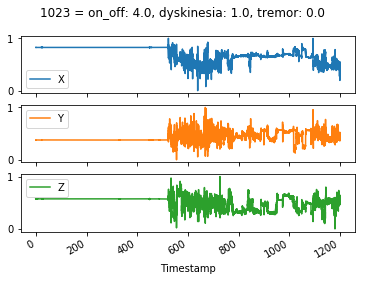

In [11]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=[#'ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
'db2e053a-0fb8-4206-891a-6f079fb14e3a']#,
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
display(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, display_df_train_data=True, path_accelerometer_plots=path_save_accelerometer_plots)


In [21]:
display(df_train_label)

,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


In [33]:
# def remove_silence():
for idx in df_train_label.index: 
    df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
    cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
    df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    pd.set_option('display.max_rows', 1000)
    display(df_train_data['X'].pct_change(periods=5))
    # TODO if le changement est < 1%, alorson remove cette valeur 

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5        0.000108
6       -0.000108
7       -0.000108
8        0.000000
9        0.000216
10      -0.000433
11       0.000216
12       0.000325
13      -0.000108
14      -0.000216
15       0.000216
16       0.000108
17       0.000000
18       0.000000
19       0.000108
20      -0.000108
21       0.000108
22      -0.000324
23       0.000000
24       0.000000
25      -0.000325
26      -0.000325
27       0.000000
28      -0.000108
29       0.000433
30       0.000216
31       0.000541
32      -0.000108
33      -0.000108
34      -0.000541
35       0.000000
36      -0.000216
37      -0.000216
38       0.000433
39      -0.000433
40       0.000325
41      -0.000108
42       0.000433
43      -0.000541
44       0.000216
45      -0.000108
46      -0.000216
47       0.000216
48       0.000108
49       0.000541
50      -0.000108
51       0.000108
52      -0.000216
53       0.000108
54      -0.000433
55      -0

display df occurences


,subject_id,symptom,symptom_value,occurence
0,1007,on_off,0.0,1
1,1007,dyskinesia,0.0,1
2,1007,tremor,2.0,1
3,1023,on_off,4.0,2
4,1023,on_off,0.0,1
5,1023,on_off,3.0,1
6,1023,dyskinesia,0.0,1
7,1023,dyskinesia,4.0,1
8,1023,dyskinesia,3.0,1
9,1023,dyskinesia,1.0,1


Nb subject_id :  5


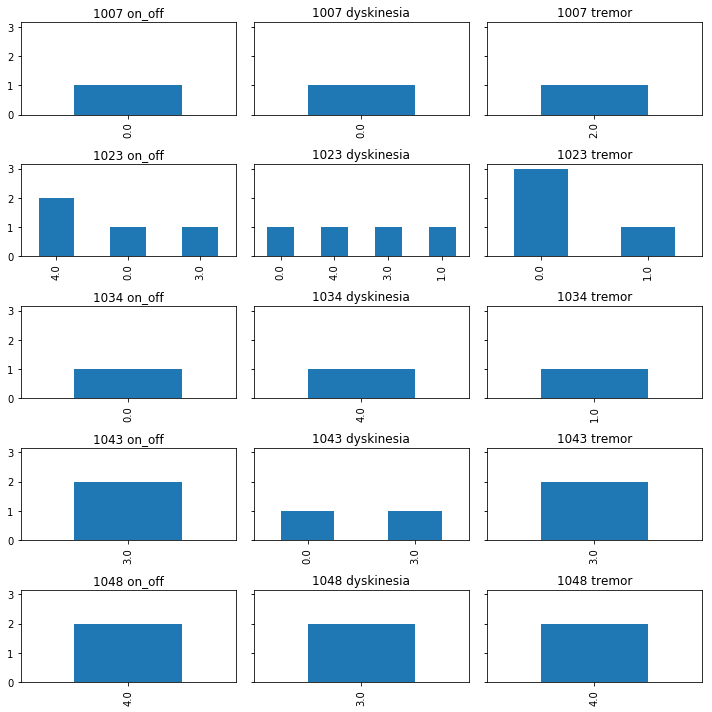

In [10]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

In [39]:
# List of interesting measurement id we want to look at 
# list_measurement_id=['ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
# 'db2e053a-0fb8-4206-891a-6f079fb14e3a',
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

# Filter df_train_label according to the measurement_id we are most interested in
#df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)



# KFold 
import numpy as np
from sklearn.model_selection import KFold

data_type='cis'


define_data_type(data_type=data_type)

path_train_data, df_train_label = define_data_type(data_type=data_type)





def get_k_fold(n_splits=5, subject_id=None):
    kf = KFold(n_splits)
    
    # Building the dataframe to split
    X = []

    #if we want the data split for one specific subject_id
    if subject_id: 
        df_train_label_subject_id = df_train_label.groupby('subject_id')
        X = df_train_label_subject_id.get_group(subject_id)
        
    # if we want to have all a split for all data no matter the subject_id
    # NOTE: I didn't make sure to have one subject_id represented in both train/test
    else: 
        for idx in df_train_label.index: 
            X.append([df_train_label["measurement_id"][idx]])
        X = pd.DataFrame(X)

    kf.get_n_splits(X)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    return X_train, X_test 


get_k_fold(subject_id=1004)

    


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


TRAIN: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


,measurement_id,subject_id,on_off,dyskinesia,tremor
17,3cf49c01-0499-4bad-9167-67691711204a,1004,3.0,3.0,3.0
18,ac449a51-1819-4944-b5c3-ef42be404541,1004,3.0,3.0,3.0
19,8b7abdf9-5aad-4edc-9bc4-078e29f134d6,1004,3.0,3.0,3.0
20,6110744d-3f5c-4f2e-9586-f2722352606f,1004,1.0,1.0,1.0
21,68bf2103-4211-45e9-82d7-8b4e713b2e3b,1004,2.0,2.0,2.0
22,e93b52ca-83af-46fb-baad-46c934ab4edf,1004,3.0,3.0,3.0
23,0b5f2f06-e73c-4838-9f4c-d68b909a9356,1004,1.0,1.0,1.0
24,278a1441-2e3a-467d-81c5-143e0298454b,1004,3.0,3.0,3.0
25,18cdf618-e263-4843-9640-f41ad8ff4bde,1004,1.0,1.0,1.0
26,610face1-43e9-4a7c-b1f2-20deba03d587,1004,1.0,1.0,1.0


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81] TEST: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81] TEST: [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81] TEST: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65] TEST: [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


# REAL-PD Database

This database, originally named "Parkinson@Home" is renamed to "Real-PD" for this challenge. The study was made over 2 weeks, with at home monitoring. 

The devices used are an android phone, a motorolla watch. 
- `smartwatch_accelerometer` and `smartwatch_gyroscope` : Motorolla Watch
- `smartphone_accelerometer` : Android phone 

-> Question: so is the smartwatch & smartphone accelerometer should measure the same movements? 

The REAL-PD database has many missing values. 

The subject_id `hbv013` is the only one without missing data. Other patients all have at least one missing symptom (`diskenisia`, ) or two (`on/off and tremor`, `on_off and dyskinesia`, `dyskinesia and tremor`) missing.

Measurements id with no data (`on_off`, `dyskinesia` and `tremor` are all missing):
- `b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8`
- `b598c177-4e38-4ea8-8543-bd8f7e580f96`
- `cf841bf8-0082-4ea3-999f-1f43e39a8dc6`
- `b1e15f8a-109f-459b-ba87-46899240ee66`
- `6f0e2580-56ec-4743-9356-d3e4d9a0aee5`
- `773536f6-9b70-43d0-b099-5d167d74924a`
- `54a0e841-ad45-4ba7-ac83-1785c5f7748b`
- `cd9ed2e2-7e04-44c7-b041-7788f133c193`
- `a6954a91-338b-4523-9e4a-5e69a8fac206`

The 3 symptoms are reported as follows in this dataset: 
- `on_off = {0,1}`
  - `Off` : 0 (medication is wearing off) 
  - `On` : 1 (medication is working)
  
- `dyskinesia = {0,1,2}`
  - Without dyskinesia: 0 
  - Non-troublesome dyskinesia: 1 
  - Severe dyskinesia: 2 
  
- `tremor = {0,1,2,3,4}` 
The description of the database mentions `tremor` is rated from 0 to 4 according to its severity, but from all the data, the maximum value of `tremor` recorded is 3. 

Data:
- ancillary
- clinical : UPDRS evaluation score 
- demographics : #TODO


,measurement_id,subject_id,on_off,dyskinesia,tremor
222,5b4c7c81-659d-40ea-a1fd-59622074fd10,hbv023,NaN,NaN,2.0


,t,x,y,z
0,0.000,-7.943961,-4.496311,-0.751779
1,0.001,9.730036,-0.526724,2.858677
2,0.021,-7.795521,-4.438850,-0.780510
3,0.037,9.763555,-0.512359,2.715025
4,0.041,-7.958326,-4.218584,-1.019930
5,0.053,-7.824251,-4.022259,-0.847547
6,0.060,9.591172,-0.526724,2.767697
7,0.080,-7.776367,-3.825934,-0.732626
8,0.081,9.763555,-0.526724,2.834735
9,0.100,9.581595,-0.459687,2.810793


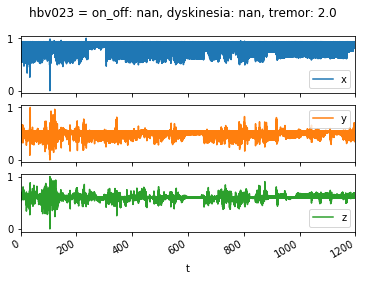

In [37]:
data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
data_real_subtype='smartwatch_accelerometer'
#data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=['5b4c7c81-659d-40ea-a1fd-59622074fd10']#'ee053d95-c155-400d-ae42-fe24834ad4a9',
# 'ce51ee31-8553-4321-9f83-8cd3dabe2f66',
# 'e07708ff-7b8d-4070-af70-3aa81423ab5b',
# #'7d3f4b7a-167f-4a26-9062-94ce9d8794c1',
# '99af8d14-cd09-4107-9502-355378ba4e08',
# #'7d5ac31a-cb53-40f7-8188-0b13724ea55c',
# '9e43840b-dd89-498b-af1a-a62896a4d5d9',
# 'e391f546-bf8a-46c7-a16c-95bc02f40629']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
#display(df_train_label)

###  Plot the accelerometer data 
# Path example: /home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/real/smartwatch_gyroscope/
path = path_save_accelerometer_plots+'/'+data_type+'/'+data_real_subtype+'/'
plot_accelerometer(data_type=data_type, display_df_train_data=True, path_accelerometer_plots=path)


In [12]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

display df occurences


,subject_id,symptom,symptom_value,occurence
0,hbv012,on_off,-1.0,42
1,hbv012,dyskinesia,-1.0,42
2,hbv012,tremor,0.0,29
3,hbv012,tremor,1.0,8
4,hbv012,tremor,2.0,5
5,hbv013,on_off,0.0,43
6,hbv013,on_off,1.0,22
7,hbv013,on_off,-1.0,3
8,hbv013,dyskinesia,0.0,54
9,hbv013,dyskinesia,1.0,11


Nb subject_id :  12


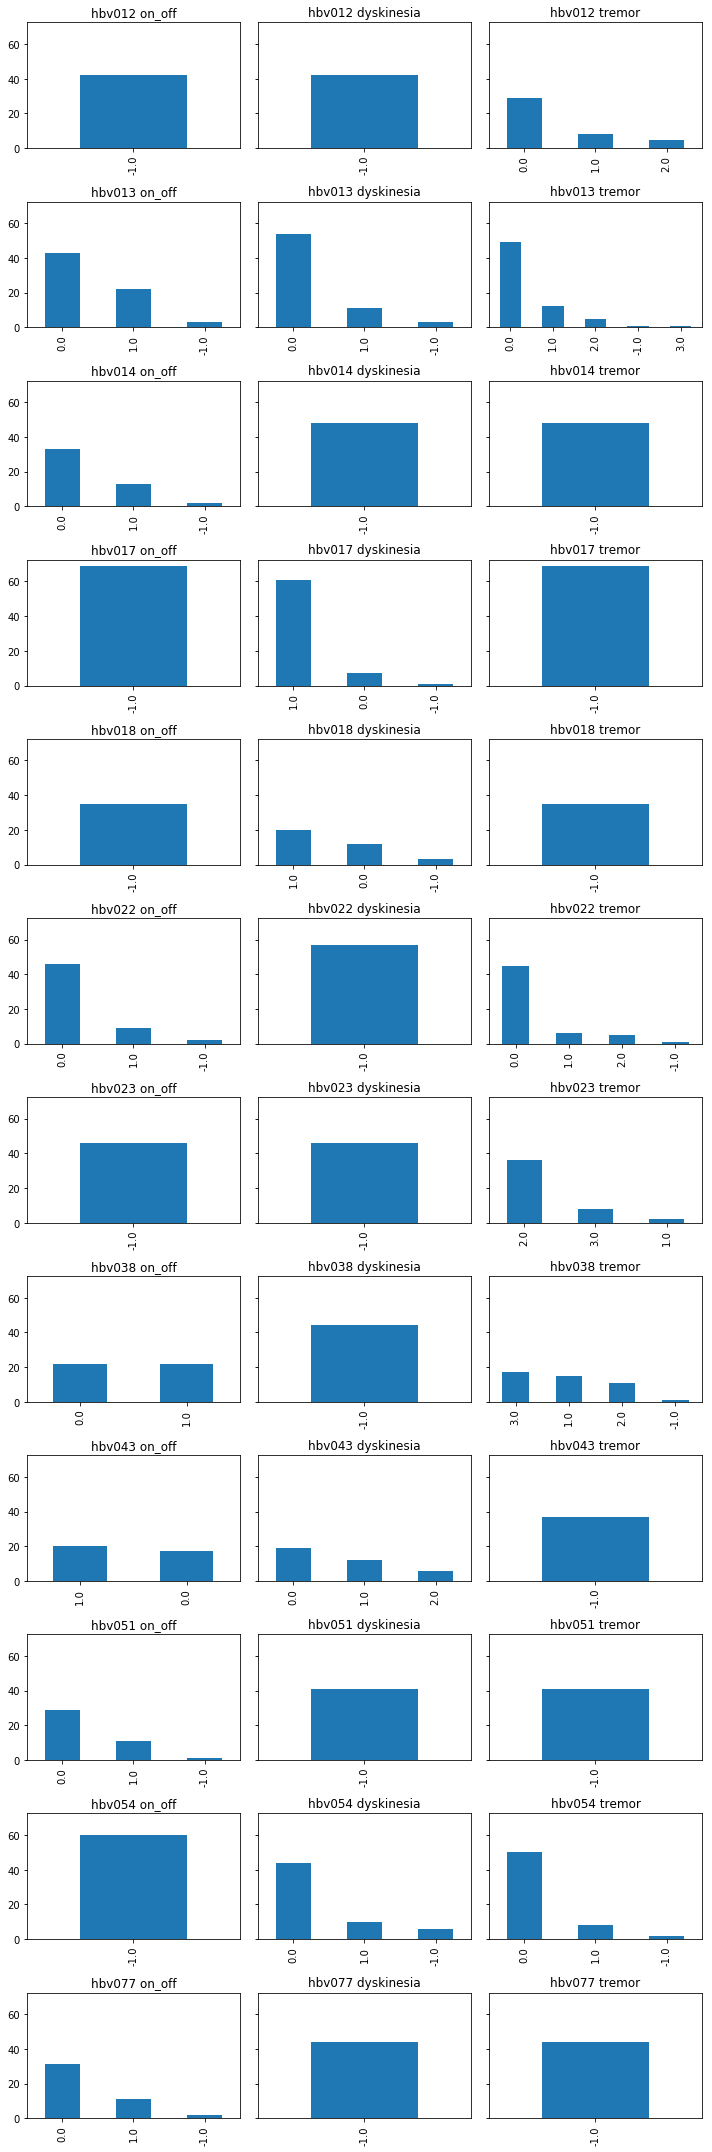

In [13]:
# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

# Comparing both databases


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">CIS-PD</th>
    <th class="tg-0pky">REAL-PD</th>
  </tr>
  <tr>
    <td class="tg-0pky"># of subject_id training</td>
    <td class="tg-c3ow">16</td>
    <td class="tg-c3ow">12</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of female training</td>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">7</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of male training</td>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">5</td>
  </tr>
  <tr>
    <td class="tg-0pky">Age average (std deviation)</td>
    <td class="tg-c3ow">62.8125 (10.857)</td>
    <td class="tg-c3ow">59.833 (5.828)</td>
  </tr>
</table>



In [14]:
# DataFrame for specified subject_id
display(df_train_label_subject_id.get_group('hbv013'))
#print(display(df_train_label_subject_id.get_group('hbv013')['tremor'].value_counts()))

# Plots for a specific subject_id the 3 symptoms 
# df_train_label_subject_id.get_group('hbv014')['tremor'].value_counts().plot(kind='bar', title='tremor')
# df_train_label_subject_id.get_group('hbv014')['dyskinesia'].value_counts().plot(kind='bar', title='dys')
# df_train_label_subject_id.get_group('hbv014')['on_off'].value_counts().plot(kind='bar', title='on_off')


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
2,d3c89012-3ab9-4014-b577-61ff05e31968,hbv013,1.0,0.0,0.0
3,5c42911d-0ebd-47ba-9925-dd5ab1c0ed61,hbv013,1.0,0.0,1.0
4,235472d5-ad2e-4c76-947e-358c9d8c1280,hbv013,1.0,0.0,0.0
5,274f5bc8-2e4f-4d7c-a546-b65b7d6bd01e,hbv013,0.0,0.0,-1.0
6,39cf118c-e2bb-4e3f-adb1-d200ee20e1fa,hbv013,0.0,1.0,0.0
7,ecbeea40-8770-455d-90a6-597e7f896e1b,hbv013,0.0,1.0,0.0
8,d3171986-f881-4fa8-9c61-a72a3ad3ae26,hbv013,1.0,0.0,0.0
9,96090095-7b0f-423f-ac9a-d69b7d1b638c,hbv013,0.0,1.0,0.0


In [15]:
20*60/59848

0.02005079534821548

In [16]:
# Analysis of the data to find edge cases 


# Create variable with TRUE if nationality is USA
dys = df_train_label['dyskinesia'] > 1

# Create variable with TRUE if age is greater than 50
tre = df_train_label['on_off'] > 0

# Select all cases where nationality is USA and age is greater than 50
df_train_label[dys & tre]

,measurement_id,subject_id,on_off,dyskinesia,tremor
457,ead7c4df-53fc-493e-be19-39e5c269f003,hbv043,1.0,2.0,NaN
458,f71ba377-2f59-4605-ae3f-8221d2120c7f,hbv043,1.0,2.0,NaN
461,6792f751-13bb-475c-9591-a6048f0f7353,hbv043,1.0,2.0,NaN
465,1f8d2c61-70d2-4292-a75a-1e5164460e06,hbv043,1.0,2.0,NaN
472,5e327c6b-de1f-44d8-a1ab-4933df65d94c,hbv043,1.0,2.0,NaN
491,bc419495-0ef5-49d8-bba0-40cab15f38c8,hbv043,1.0,2.0,NaN


In [ ]:
cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [0,1,2,3,4,5,6]
        }

df = pd.DataFrame(cars, columns = ['Brand', 'Price'])
display(df)

display(df['Price'].pct_change(periods=1))

display(df['Price'].pct_change(periods=2))

display(df['Price'].pct_change(periods=5))